In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"
# 检查 GPU 是否可用  
import torch
if torch.cuda.is_available():  
   print("GPU 可用")  
   # 获取 GPU 设备数量  
   num_gpus = torch.cuda.device_count()  
   print(f"共有{num_gpus}个 GPU 设备")
   # 获取 GPU 设备信息  
   for i in range(num_gpus):  
       print(f"设备{i}: {torch.cuda.get_device_properties(i)}")  
else:  
   print("GPU 不可用")  
import sys
# sys.path.append("/workspace/notebooks/")
# sys.path.append("/workspace/notebooks/FSS/")
import numpy as np
import matplotlib.pyplot as plt

GPU 可用
共有1个 GPU 设备
设备0: _CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11011MB, multi_processor_count=68)


In [2]:
import sys
sys.path.append(f"{os.environ['HOME']}/notebooks/fss")
from src.datasets import cifar
# torchvision数据集的输出是在[0, 1]范围内的PILImage图片。
# 我们此处使用归一化的方法将其转化为Tensor，数据范围为[-1, 1]
# !wget -P /data/gongcheng/models/torch/weights/ https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# torch_weights_path="/data/gongcheng/models/torch/weights"
torch_weights_path=f"{os.environ['HOME']}/models/torch/weights"
data_root="~/datasets/cifar100"
dataset_name = 'cifar100'
trainloader,testloader,classes = cifar.get_cifar_dataloader(root=data_root,dataset=dataset_name,autoaugment=True,num_workers=20)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# from src.dns_vgg import MTL_VGG7_64_plane_base
import torch
from torch import nn
class MTL_VGG7_64_plane_dns(nn.Module):
    def __init__(self,
                 channel_num=64,
                 num_classes=10,
                 use_dns=True,
                 use_fr=True,
                 dns_ratio=0.5):
        super().__init__()
        self.dns_ratio = dns_ratio
        self.plus_fea_num = int(channel_num * dns_ratio)
        self.sub_fea_num = channel_num - self.plus_fea_num

        # block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.act1 = nn.ReLU(True)
        self.bn1 = nn.BatchNorm2d(64)
        

        self.classifer1 = nn.Sequential(
                    nn.AvgPool2d(32),
                    nn.Flatten(),
                    nn.Linear(64, num_classes)
                )

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.act2 = nn.ReLU(True)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.classifer2 = nn.Sequential(
                    nn.AvgPool2d(16),
                    nn.Flatten(),
                    nn.Linear(64, num_classes)
                )

        # block 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.act3 = nn.ReLU(True)
        self.bn3 = nn.BatchNorm2d(128)
        self.classifer3 = nn.Sequential(
                    nn.AvgPool2d(16),
                    nn.Flatten(),
                    nn.Linear(128, num_classes)
                )
        
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.act4 = nn.ReLU(True)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.classifer4 = nn.Sequential(
                    nn.AvgPool2d(8),
                    nn.Flatten(),
                    nn.Linear(128, num_classes)
                )
        

        # block 3
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.act5 = nn.ReLU(True)
        self.bn5 = nn.BatchNorm2d(256)
        self.classifer5 = nn.Sequential(
                    nn.AvgPool2d(8),
                    nn.Flatten(),
                    nn.Linear(256, num_classes)
                )
        
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.act6 = nn.ReLU(True)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool6 = nn.MaxPool2d(2, 2)
        # classifier
        self.classifer6 = nn.Sequential(
            nn.AvgPool2d(4),
            nn.Flatten(),
            # nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        f1 = self.bn1(self.act1(self.conv1(x)))
        c1 = self.classifer1(f1)
        f2 = self.pool2(self.bn2(self.act2(self.conv2(f1))))
        c2 = self.classifer2(f2)
        f3 = self.bn3(self.act3(self.conv3(f2)))
        c3 = self.classifer3(f3)
        f4 = self.pool4(self.bn4(self.act4(self.conv4(f3))))
        c4 = self.classifer4(f4)
        f5 = self.bn5(self.act5(self.conv5(f4)))
        c5 = self.classifer5(f5)
        f6 = self.pool6(self.bn6(self.act6(self.conv6(f5))))
        c6 = self.classifer6(f6)
        return [c1,c2,c3,c4,c5,c6],[f1,f2,f3,f4,f5,f6]

class STL_VGG7_64_plane(MTL_VGG7_64_plane_base):
    def forward(self, x):
        logits,features = super().forward(x)
        return logits[-1]
    
# model = MTL_VGG7_64_plane_base()
model = STL_VGG7_64_plane(num_classes=100)

In [7]:
x=torch.zeros(1,3,32,32)
model(x)

tensor([[ 0.0097,  0.2046,  0.2572,  0.0935, -0.2156, -0.0669, -0.3626, -0.0883,
          0.8245,  0.5718,  0.2787,  0.1487, -0.0501, -0.5334,  0.4530,  0.3650,
         -0.4797, -0.0073, -0.0293, -0.7292,  0.6386, -0.1352, -0.2711, -0.1982,
         -0.6073, -0.0363, -0.1388,  0.3304, -0.5773, -0.4674, -0.5428,  0.3697,
         -0.3469,  0.3962, -0.9787, -0.3460,  0.0211, -0.1735, -0.8395, -0.2057,
         -0.3186, -0.1891, -0.5336,  0.5215, -0.0088, -0.4101,  0.9816, -0.2325,
         -0.0344, -0.0623, -0.1496, -0.6476, -0.3163,  0.1586, -0.1181, -0.5792,
          0.3304, -0.1607,  0.3075, -0.5142,  0.3612, -0.3138,  0.1902,  0.1615,
          0.0218,  0.6882,  0.4684, -0.7952, -0.3055,  1.6140,  0.4651, -0.0494,
         -0.3264, -0.8150, -0.2328, -0.1983,  0.1881, -0.0018,  0.2892,  0.0460,
         -0.1453,  0.1170, -1.1655, -0.1644, -0.6019,  0.0601,  0.4371, -0.3548,
          0.4765, -0.4159, -0.3010, -1.2608,  0.3197,  0.4112,  0.3718, -0.4092,
          0.0233, -0.2345,  

# VGG on Cifar100

In [8]:
# from resnet import ResNetForCifar10,BasicBlock,resnet18
# model = ResNetForCifar10(BasicBlock, [2, 2, 2, 2], num_classes=10)
# model = resnet18().cuda()
# model=model.cuda()
# model = sdn_stl_resnet18(num_classes=100)
model = model.cuda()
model_name = "stl_vgg64_7_plane"

In [9]:
# Optimizer and Criterition
lr = 0.1
weight_decay = 1e-4
optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9,weight_decay=weight_decay)
criterion = torch.nn.CrossEntropyLoss()
epochs = 200
batch_time,data_time,loss,metrics = np.zeros(epochs,),np.zeros(epochs,),np.zeros(epochs,),np.zeros(epochs,)
val_loss,val_metrics=np.zeros(epochs,),np.zeros(epochs,)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optim,[75,130,180],gamma=0.1)

In [10]:
import sys
sys.path.append(f"{os.environ['HOME']}/packages/autoqnn")
import autoqnn
# 将程序的输出重定向到文件  
# file_path = f'./training_logs/{model_name}-on-cifar100-lr-{lr}-wd-{weight_decay}-epoch-{epochs}.txt'  
# sys.stdout = open(file_path, 'w')

# 要输出的内容  
for epoch in range(epochs):
    # adjust_learning_rate(optim,epoch,steps=[30,60])
    print(f"#################epoch {epoch+1}#################")
    print("lr=%.6f \n"%(optim.param_groups[0]['lr']))
    batch_time[epoch],data_time[epoch],loss[epoch],metric=autoqnn.core.train(trainloader,model,criterion,optim,
                       metric_meds=[autoqnn.core.top1],epoch=epoch)
    metrics[epoch]=metric[0].item()
    
    print()
    val_loss[epoch],metric = autoqnn.core.validate(testloader,model,criterion,
                      metric_meds=[autoqnn.core.top1],
                      print_freq=100)
    val_metrics[epoch] = metric[0].item()
    lr_scheduler.step()

# Save the trained parameters to disk
best_loss = np.min(val_loss)
best_metric = np.max(val_metrics)
save_file_name = f"./models/{model_name}-cifar100-loss-{best_loss}-top1-{best_metric}.pth"
torch.save(model.state_dict(),save_file_name)
print(f"save model weight to {save_file_name}")
# 关闭文件  
# sys.stdout.close()  

#################epoch 1#################
lr=0.100000 

Epoch: [0][100/100]	Time 0.100 (0.141)	Data 0.066 (0.072)	Loss 3.9185 (4.1778)	top1 9.600 (6.828)
Test: [0/100]	Time 0.431 (0.431)	Loss 3.9312 (3.9312)	top1 16.000 (16.000)
 * top1 12.000
#################epoch 2#################
lr=0.100000 

Epoch: [1][100/100]	Time 0.131 (0.118)	Data 0.098 (0.073)	Loss 3.4512 (3.6939)	top1 16.600 (13.752)
Test: [0/100]	Time 0.403 (0.403)	Loss 3.3516 (3.3516)	top1 21.000 (21.000)
 * top1 20.500
#################epoch 3#################
lr=0.100000 

Epoch: [2][100/100]	Time 0.109 (0.118)	Data 0.077 (0.076)	Loss 3.3204 (3.3522)	top1 18.200 (19.526)
Test: [0/100]	Time 0.386 (0.386)	Loss 3.1553 (3.1553)	top1 21.000 (21.000)
 * top1 26.370
#################epoch 4#################
lr=0.100000 

Epoch: [3][100/100]	Time 0.118 (0.118)	Data 0.084 (0.075)	Loss 3.0219 (3.0775)	top1 26.600 (24.556)
Test: [0/100]	Time 0.401 (0.401)	Loss 2.6166 (2.6166)	top1 34.000 (34.000)
 * top1 36.800
#################e

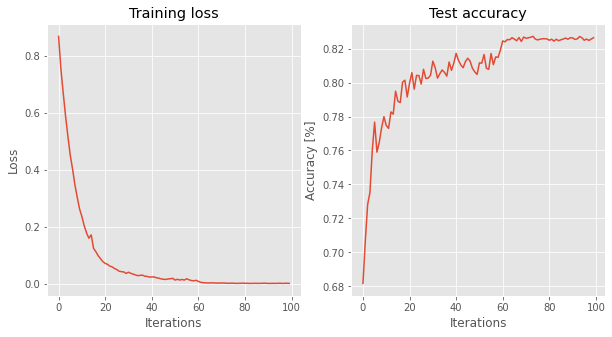

In [16]:
# draw the training curve
from train_utils import display_loss_plot
plt.style.use("ggplot")
plt.figure(figsize=(10,5))
# Plot training loss over epochs
loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
plt.subplot(1,2,1)
display_loss_plot(loss_per_epoch)
# Plot test accuracy over epochs
acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
plt.subplot(1,2,2)
display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")
plt.show()

In [8]:
# Save the trained parameters to disk
torch.save(model.state_dict(), 
    "/workspace/notebooks/FSS/models/resnet18-cifar100-SDN-66.14-71.95-76.54-76.82.pth")